<a href="https://colab.research.google.com/github/jan-Kulpas/studia-computer-vision/blob/master/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN to generate face images

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2023/12/21<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step` on CelebA images.

## Setup

In [ ]:
import keras
import tensorflow as tf
import numpy as np

from keras import layers, datasets
from keras import ops
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import gdown
from zipfile import ZipFile


## Prepare CelebA data

We'll use face images from the CelebA dataset, resized to 64x64.

In [ ]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

Create a dataset from our folder, and rescale the images to the [0-1] range:

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)


Found 202599 files.


I0000 00:00:1749814629.831008      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
IMAGE_SIZE = 96 #299
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
num_classes = 10

(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = np.expand_dims(train_images, axis=3)
dataset = train_images

Let's display a sample image:

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

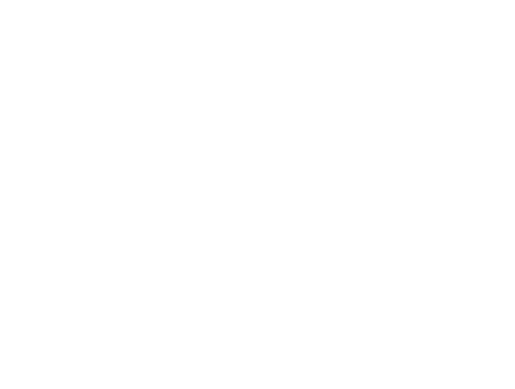

In [ ]:

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 14, 14, 64)          │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_42 (ReLU)                      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 7, 7, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_43 (ReLU)                      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 4, 4, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_44 (ReLU)                      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 396,609 (1.51 MB)

 Trainable params: 396,609 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(7 * 7 * 128),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=1, padding="same"),
        layers.ReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.ReLU(negative_slope=0.2),
        layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                     │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_12 (Reshape)                 │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_33                  │ (None, 7, 7, 128)           │         262,272 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_48 (ReLU)                      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_34                  │ (None, 14, 14, 256)         │         524,544 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_49 (ReLU)                      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_35                  │ (None, 28, 28, 512)         │       2,097,664 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_50 (ReLU)                      │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 28, 28, 1)           │          12,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,706,369 (14.14 MB)

 Trainable params: 3,706,369 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

## Override `train_step`

In [ ]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images

        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Create a callback that periodically saves generated images

In [ ]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


## Train the end-to-end model

In [ ]:
epochs = 10  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - d_loss: 0.3018 - g_loss: 2.5470
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - d_loss: 0.5036 - g_loss: 2.3706
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - d_loss: 0.6289 - g_loss: 0.9580
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - d_loss: 0.6512 - g_loss: 0.9499
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - d_loss: 0.6581 - g_loss: 0.8792
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - d_loss: 0.6527 - g_loss: 0.8581
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - d_loss: 0.6621 - g_loss: 0.8591
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - d_loss: 0.6542 - g_loss: 0.8671
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - d_loss: 0.6516 - g_loss: 0.8652
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - d_loss: 0.6450 - g_loss: 0.8848


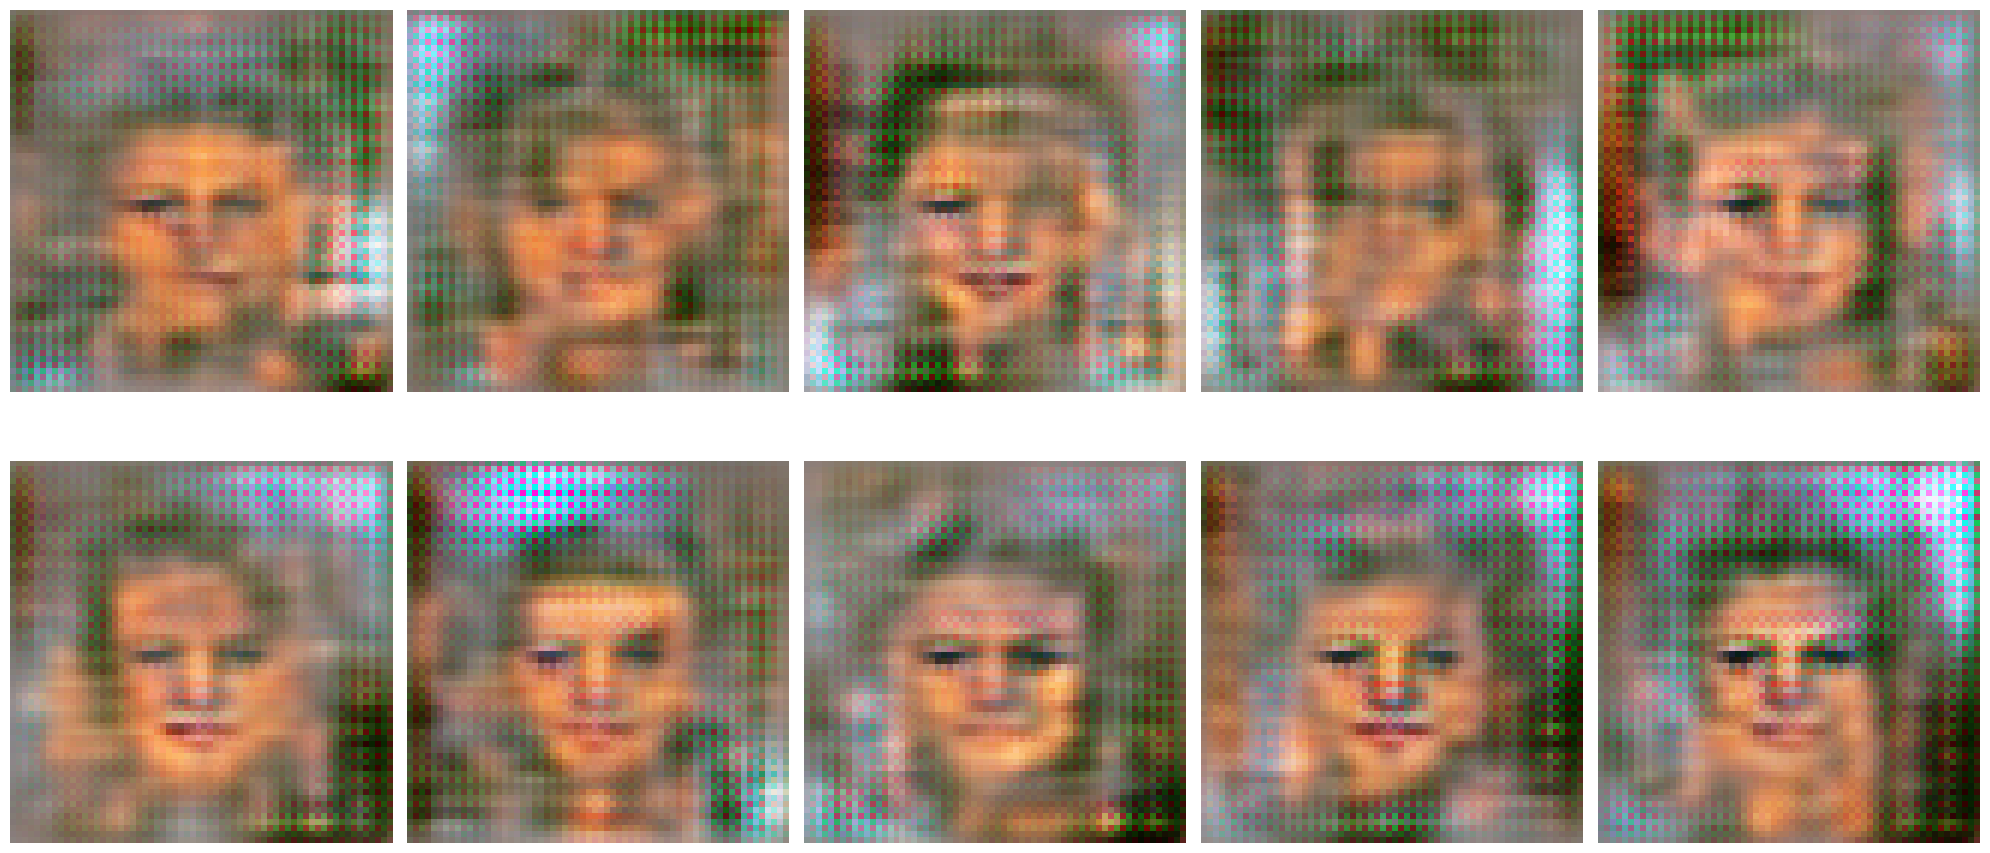

In [ ]:
for epoch in range(epochs):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    # Flatten the axes array to simplify indexing
    axes = axes.flatten()
    # Display each image
    for i in range(10):
        path = "generated_img_%03d_%d.png" % (epoch, i)
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

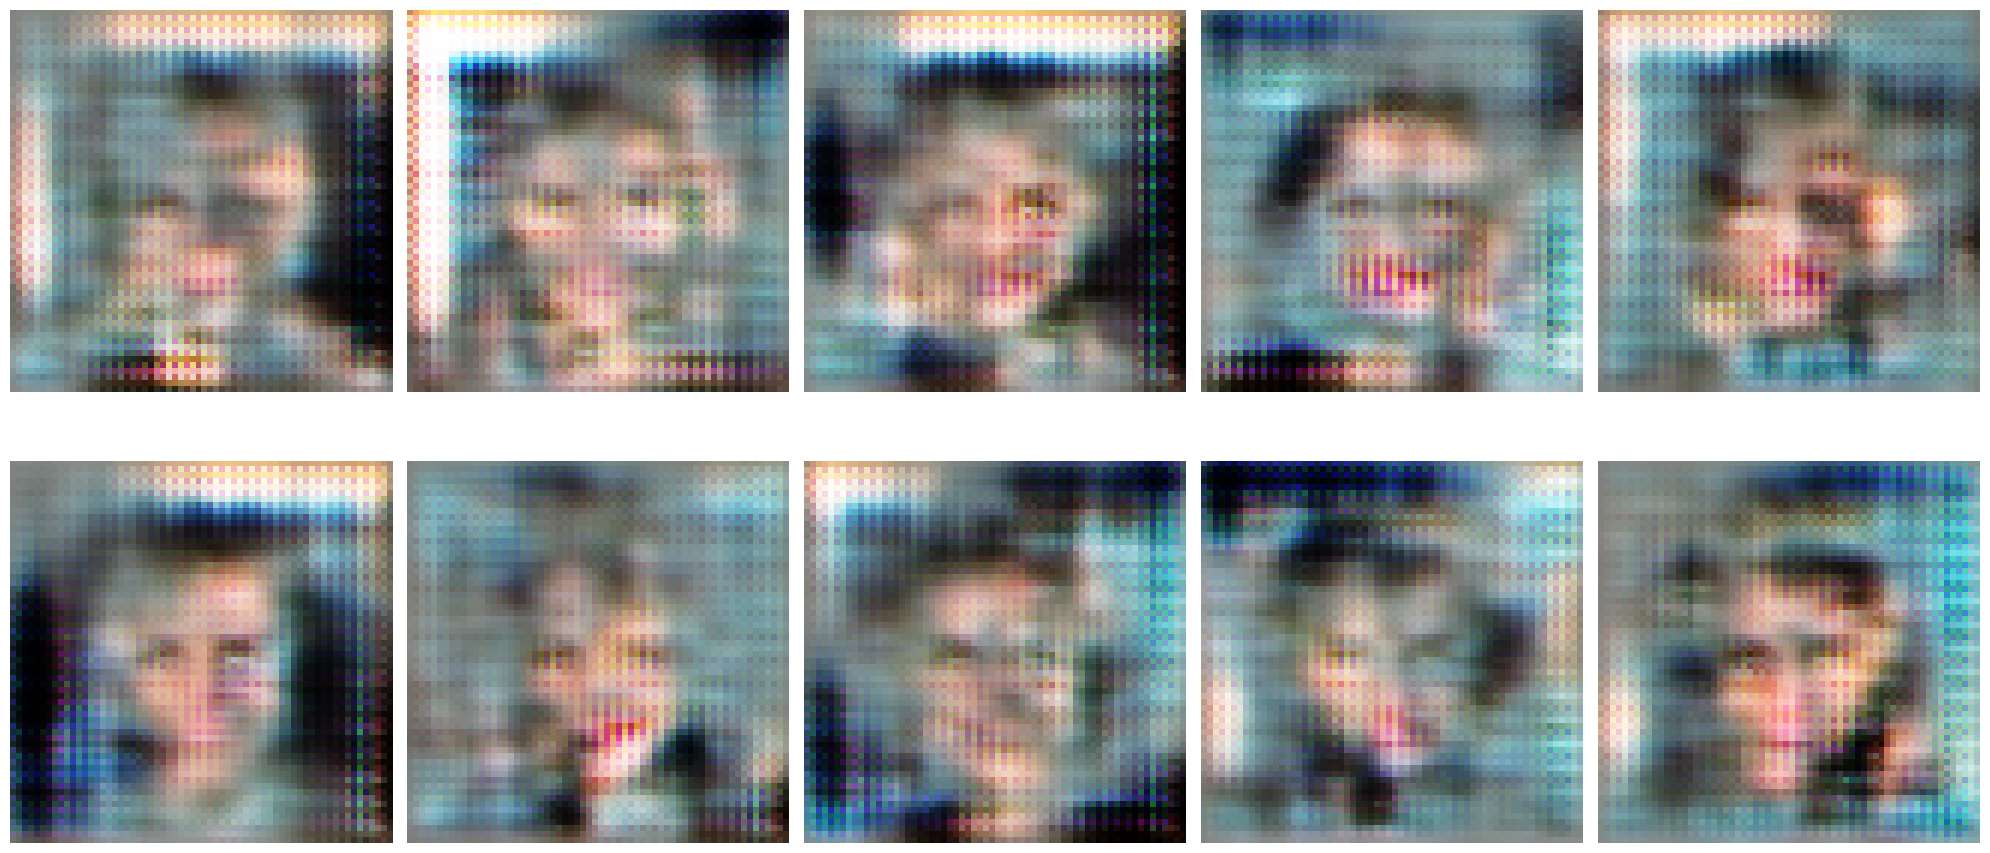

In [ ]:
for epoch in range(epochs):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    # Flatten the axes array to simplify indexing
    axes = axes.flatten()
    # Display each image
    for i in range(10):
        path = "generated_img_%03d_%d.png" % (epoch, i)
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

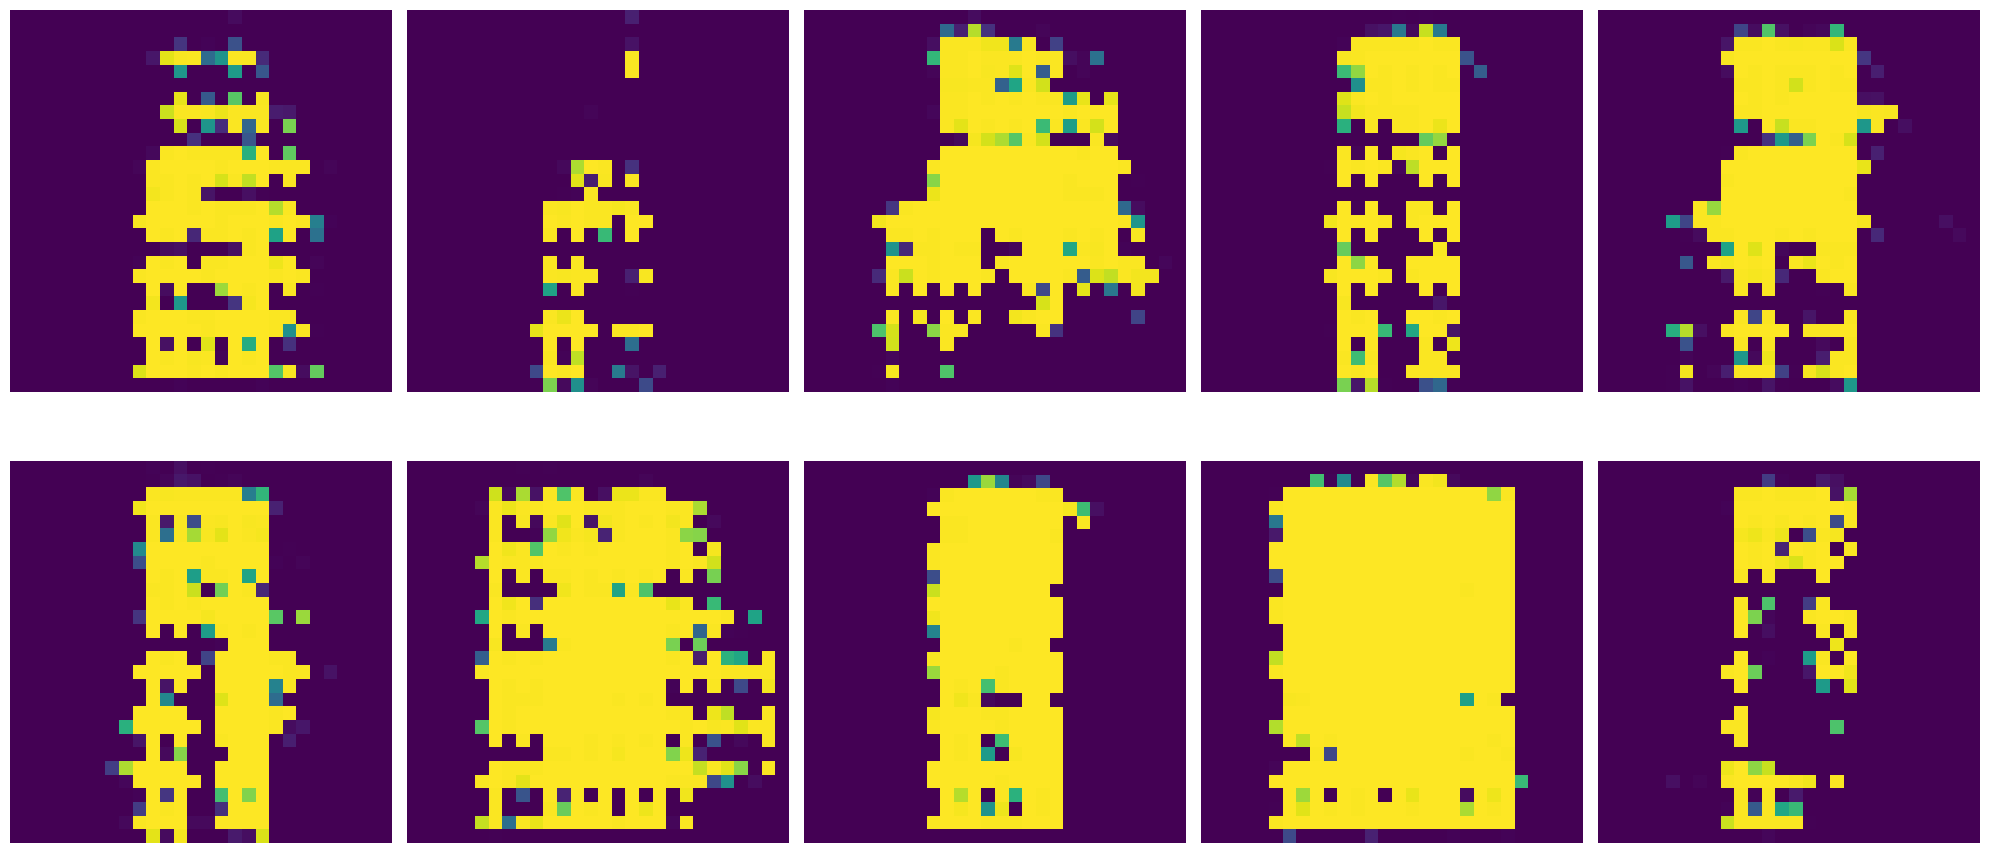

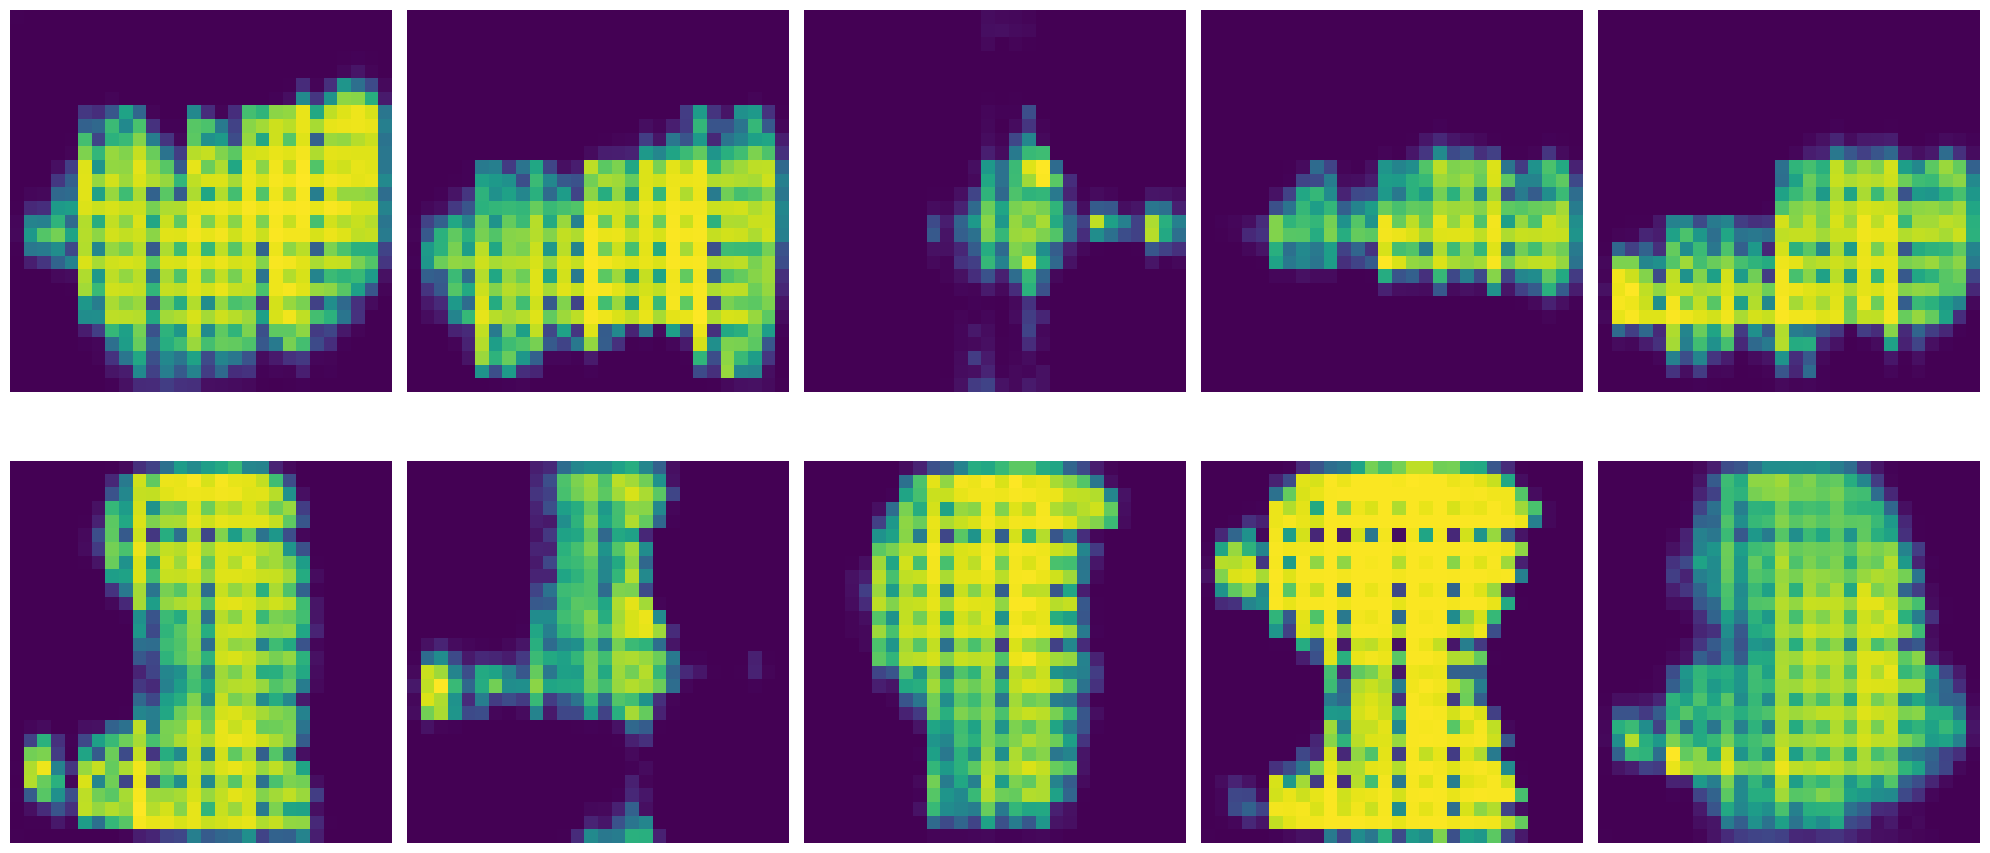

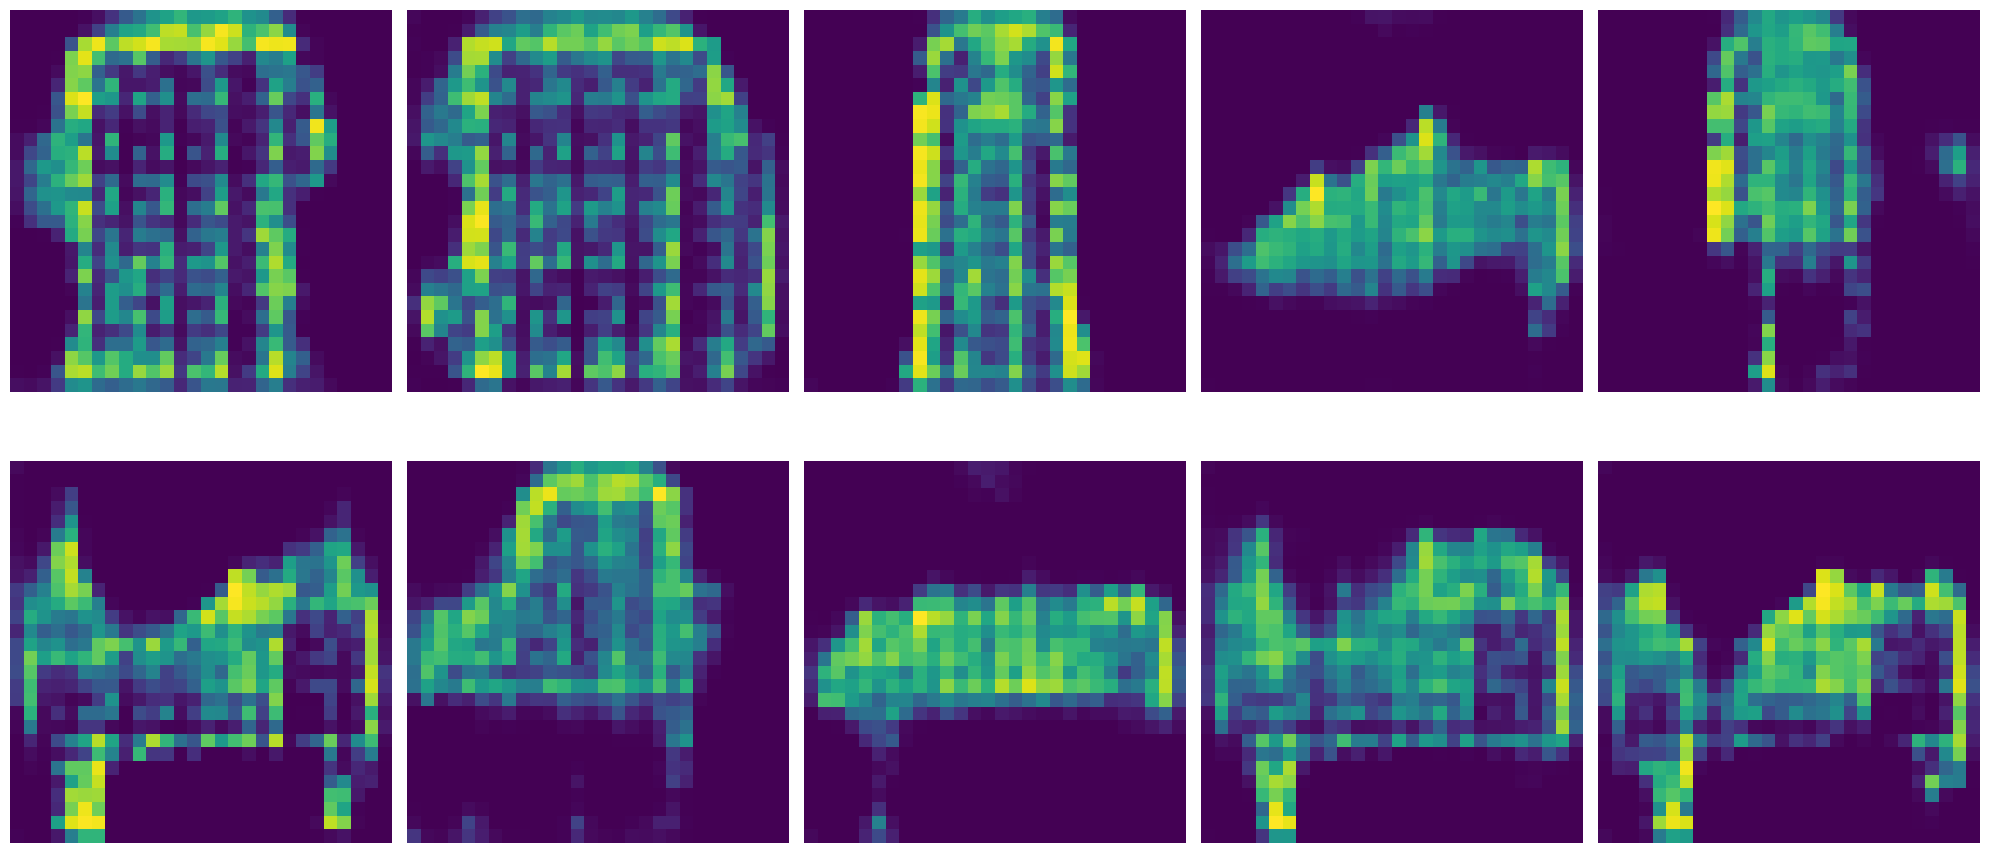

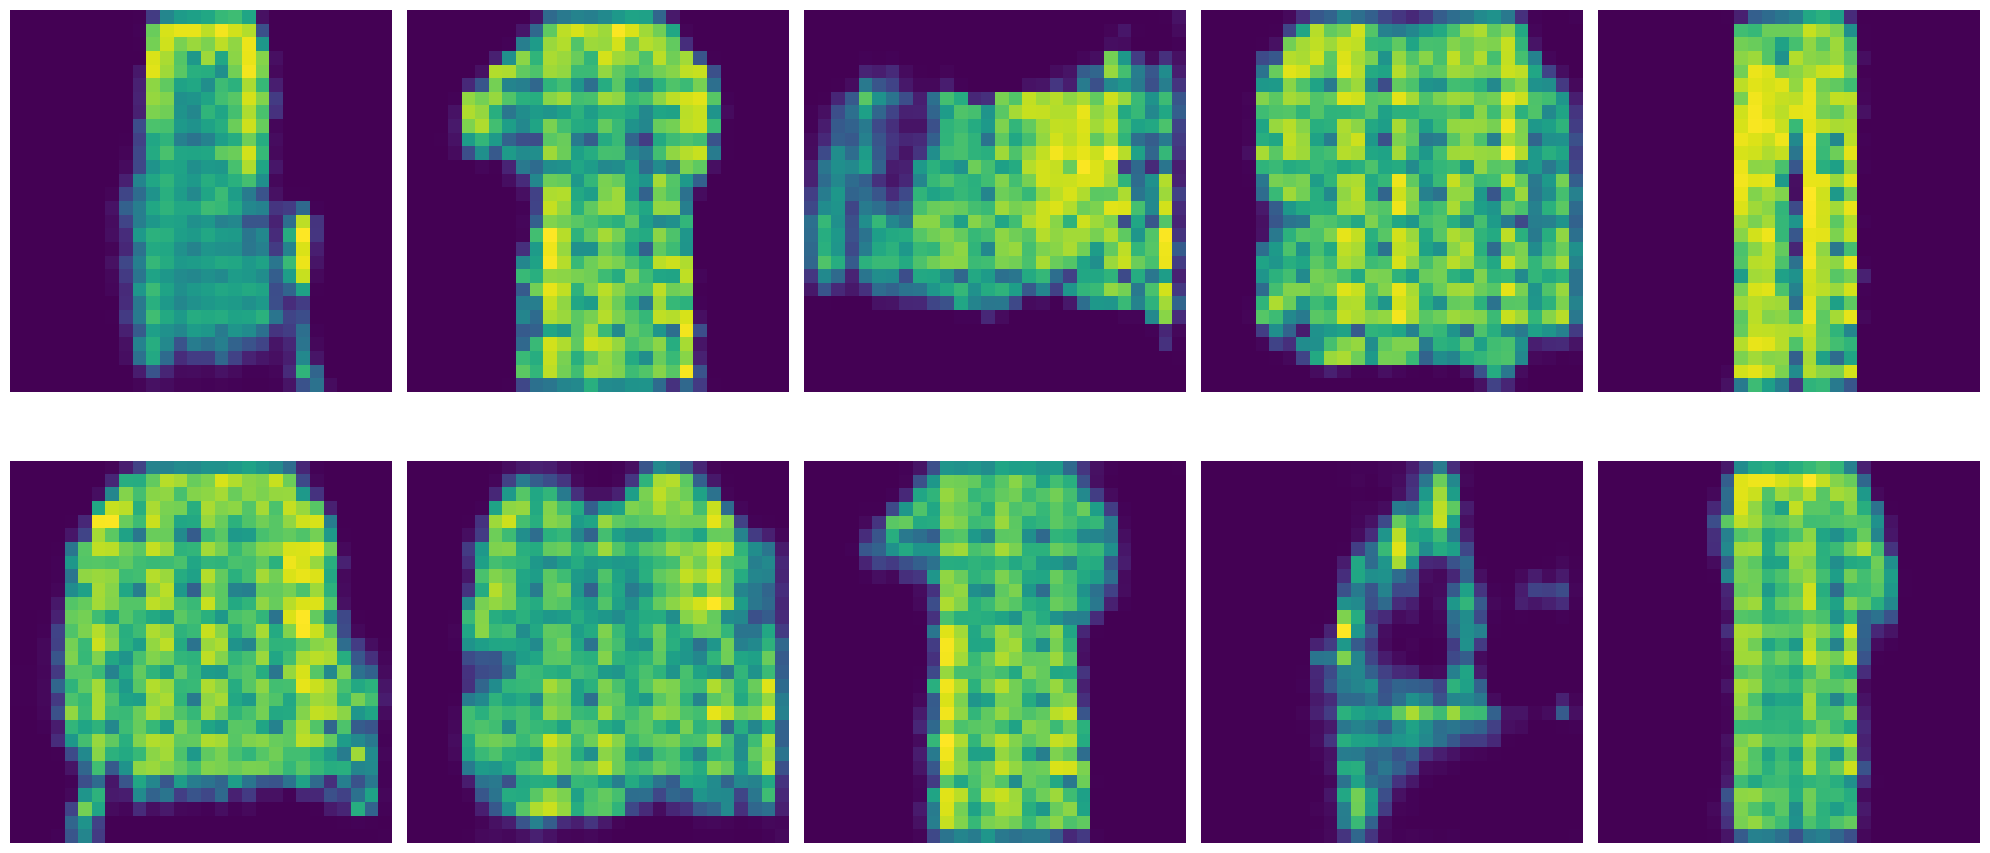

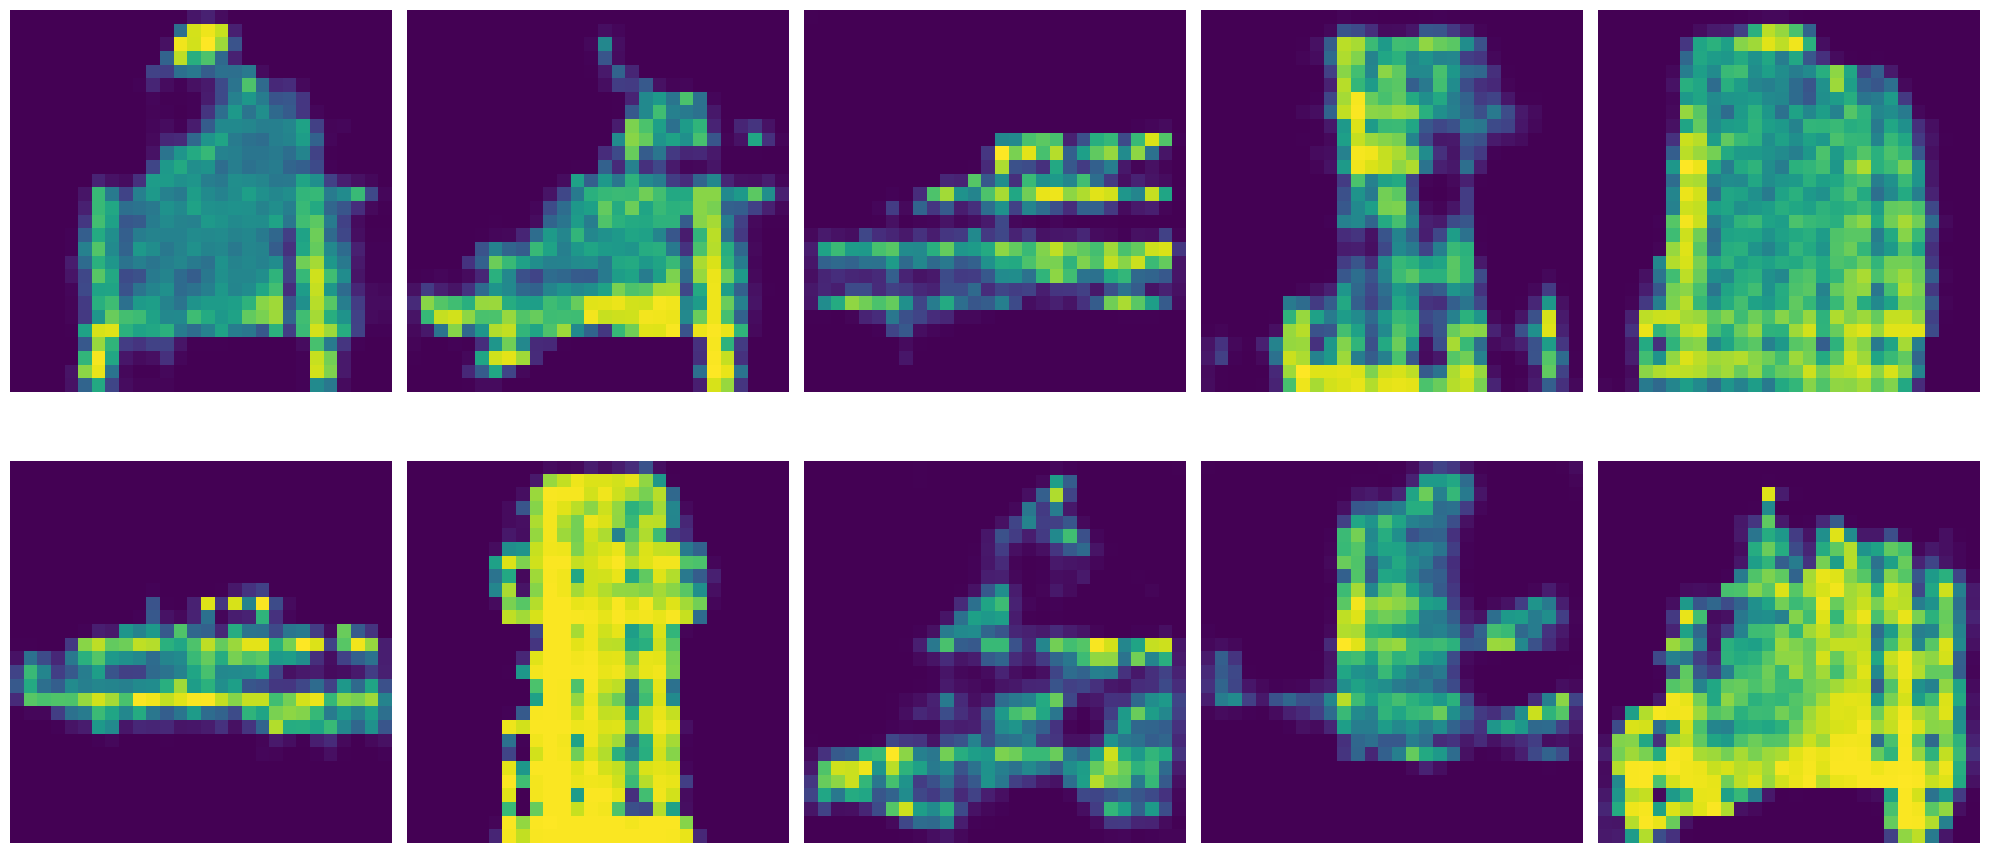

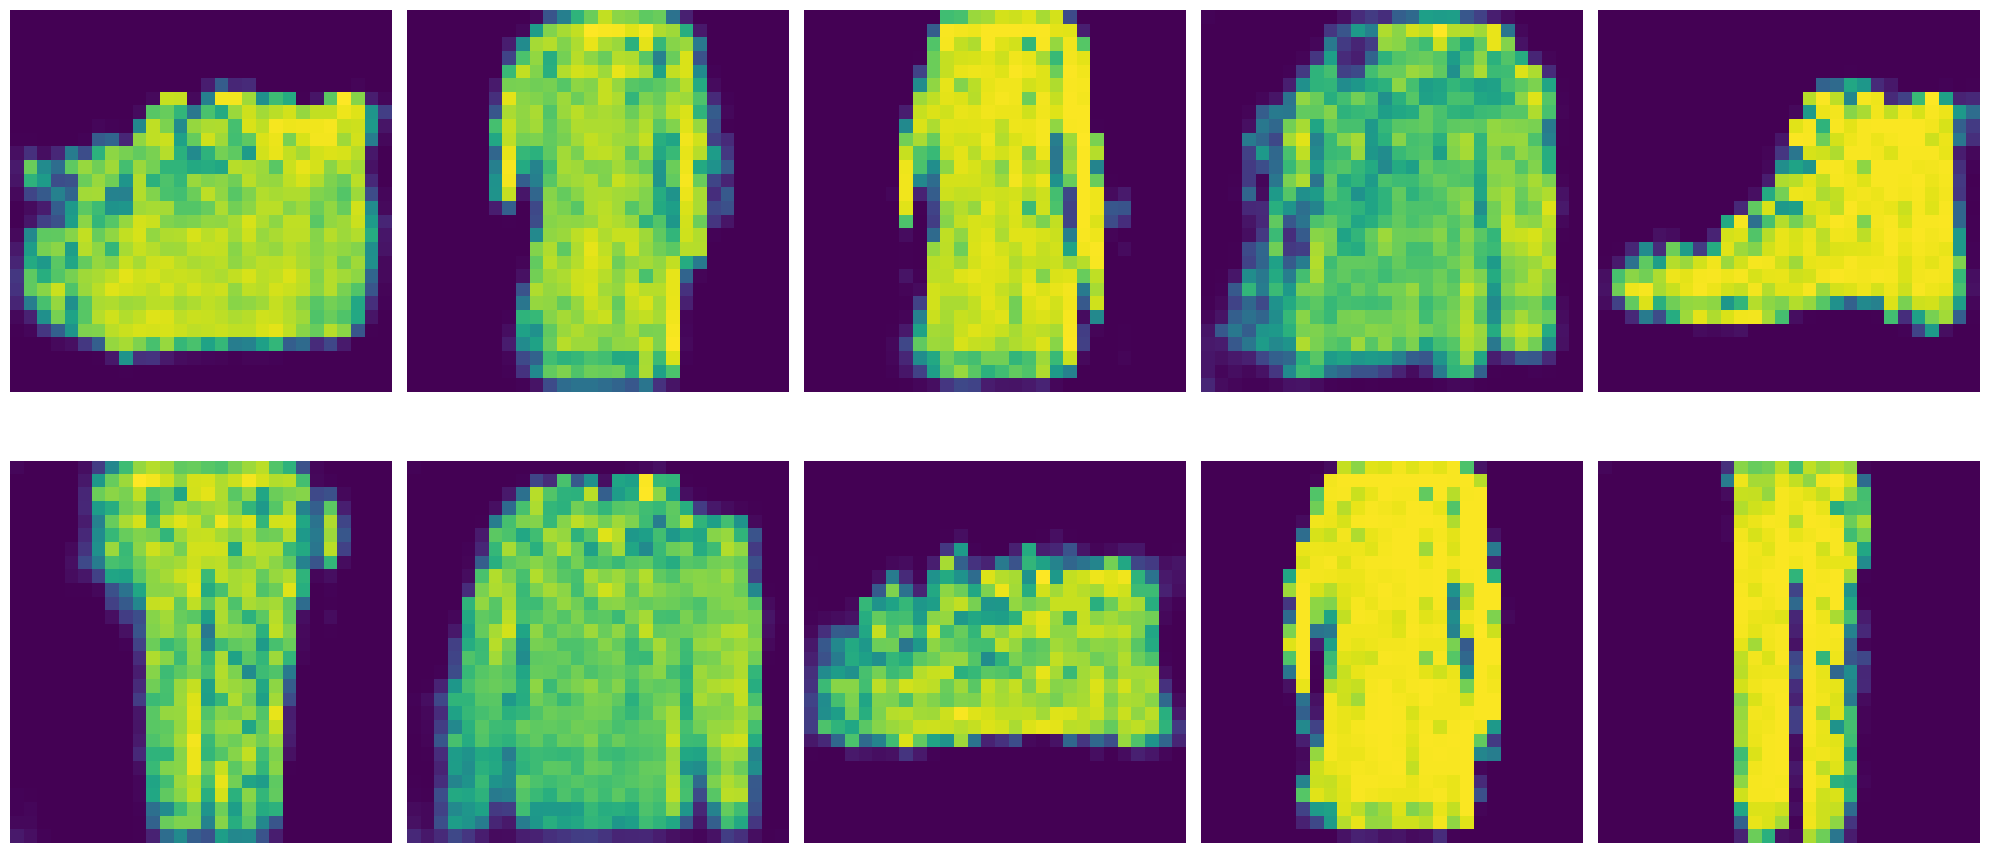

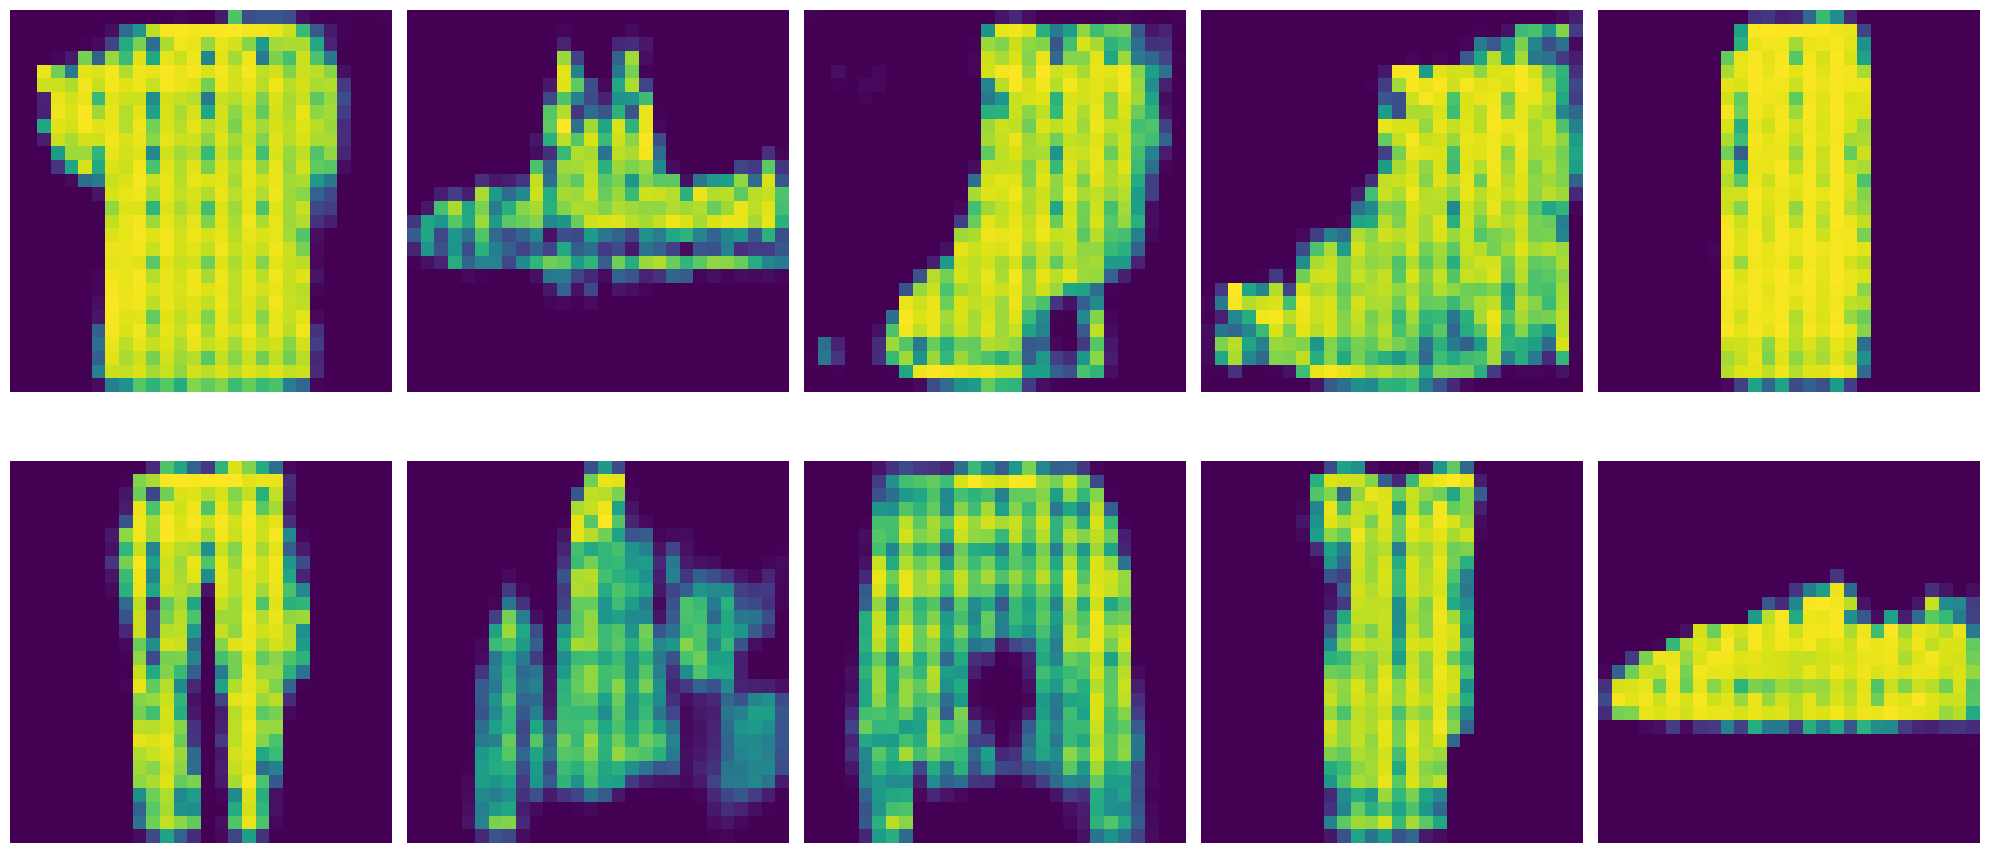

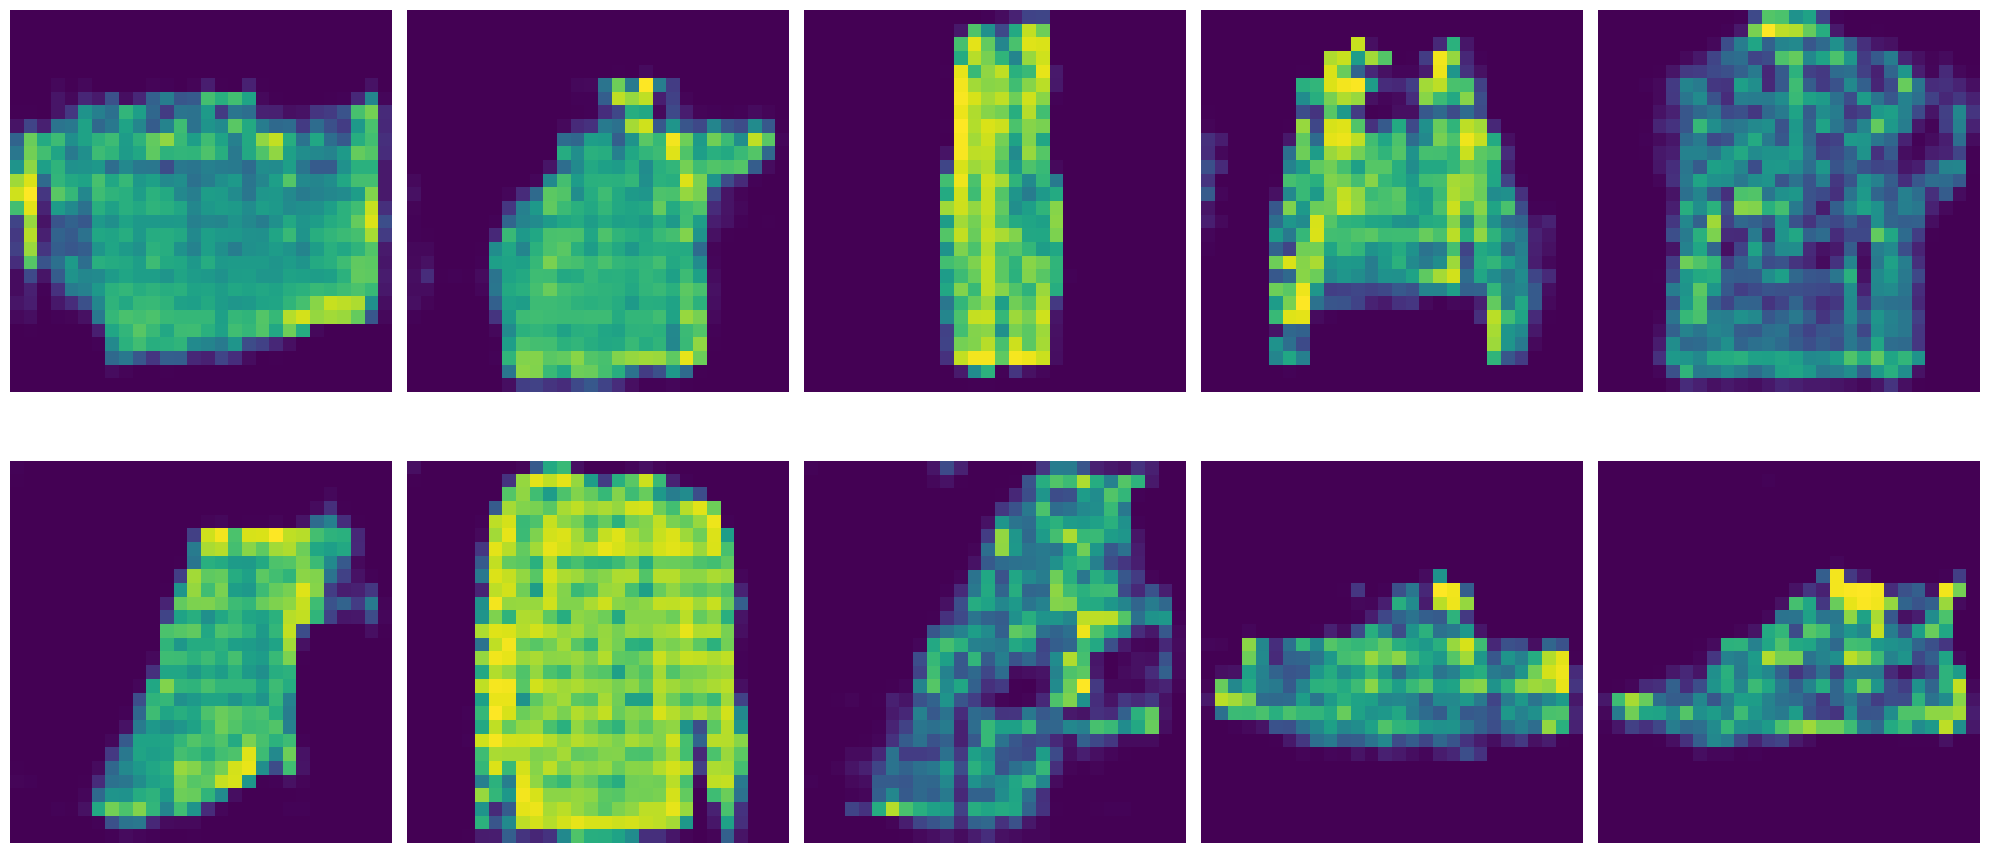

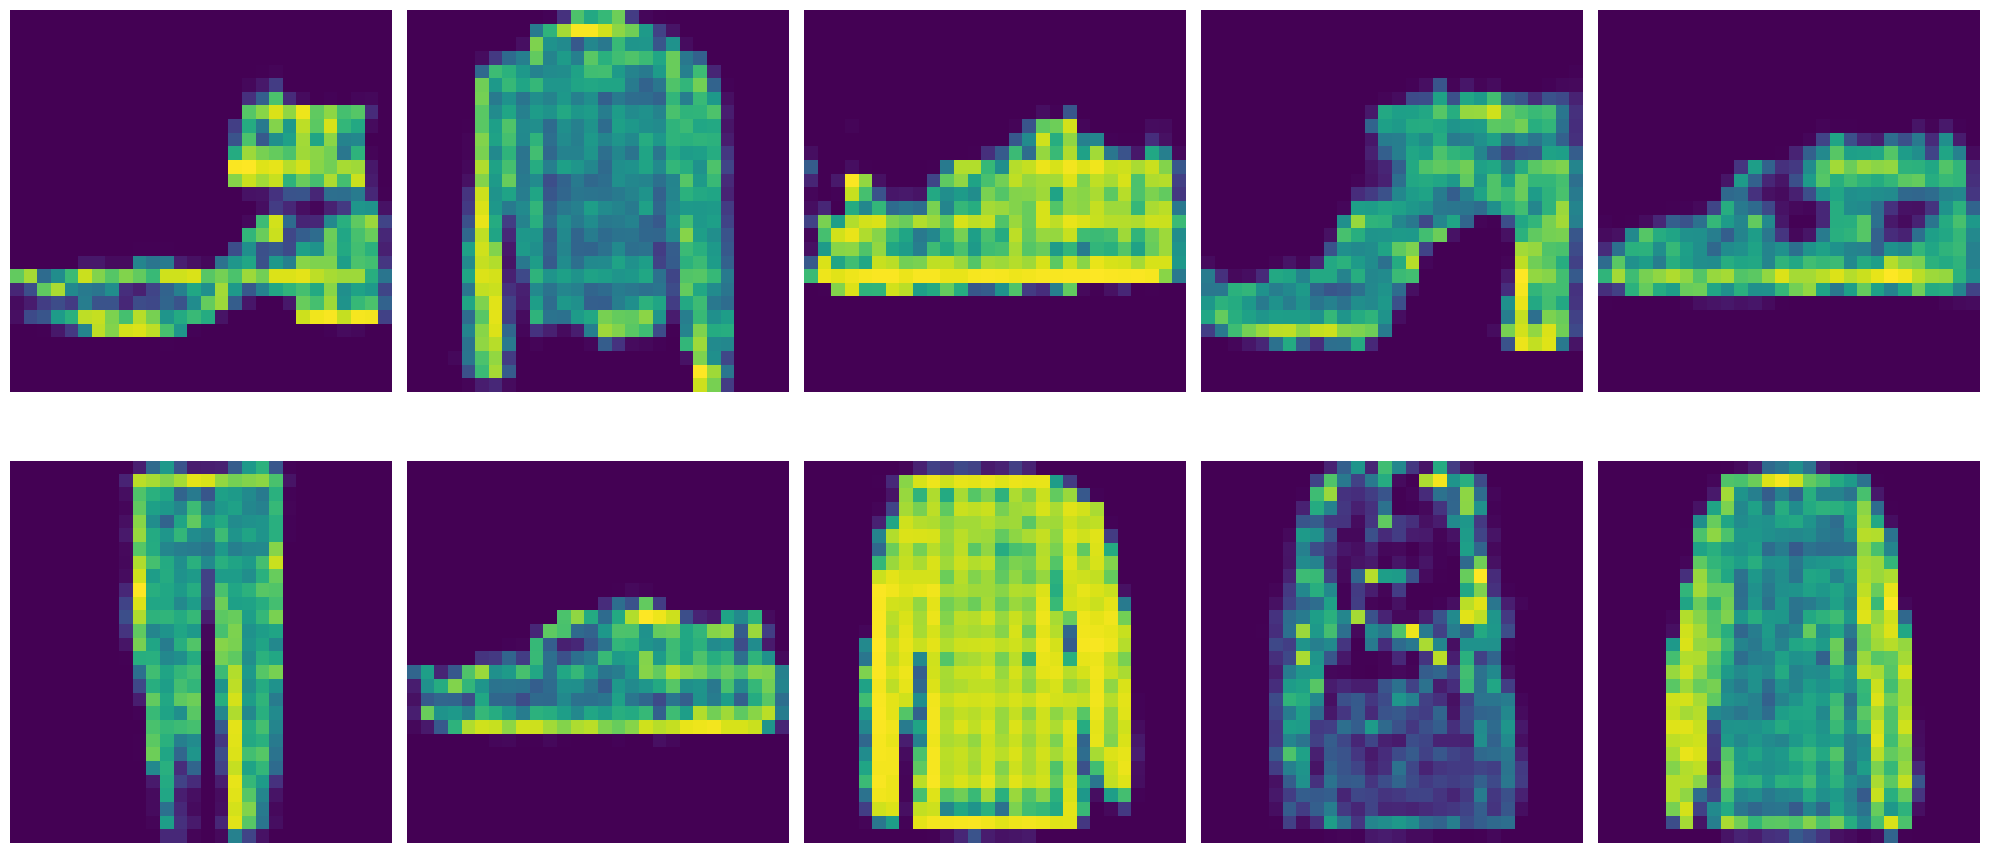

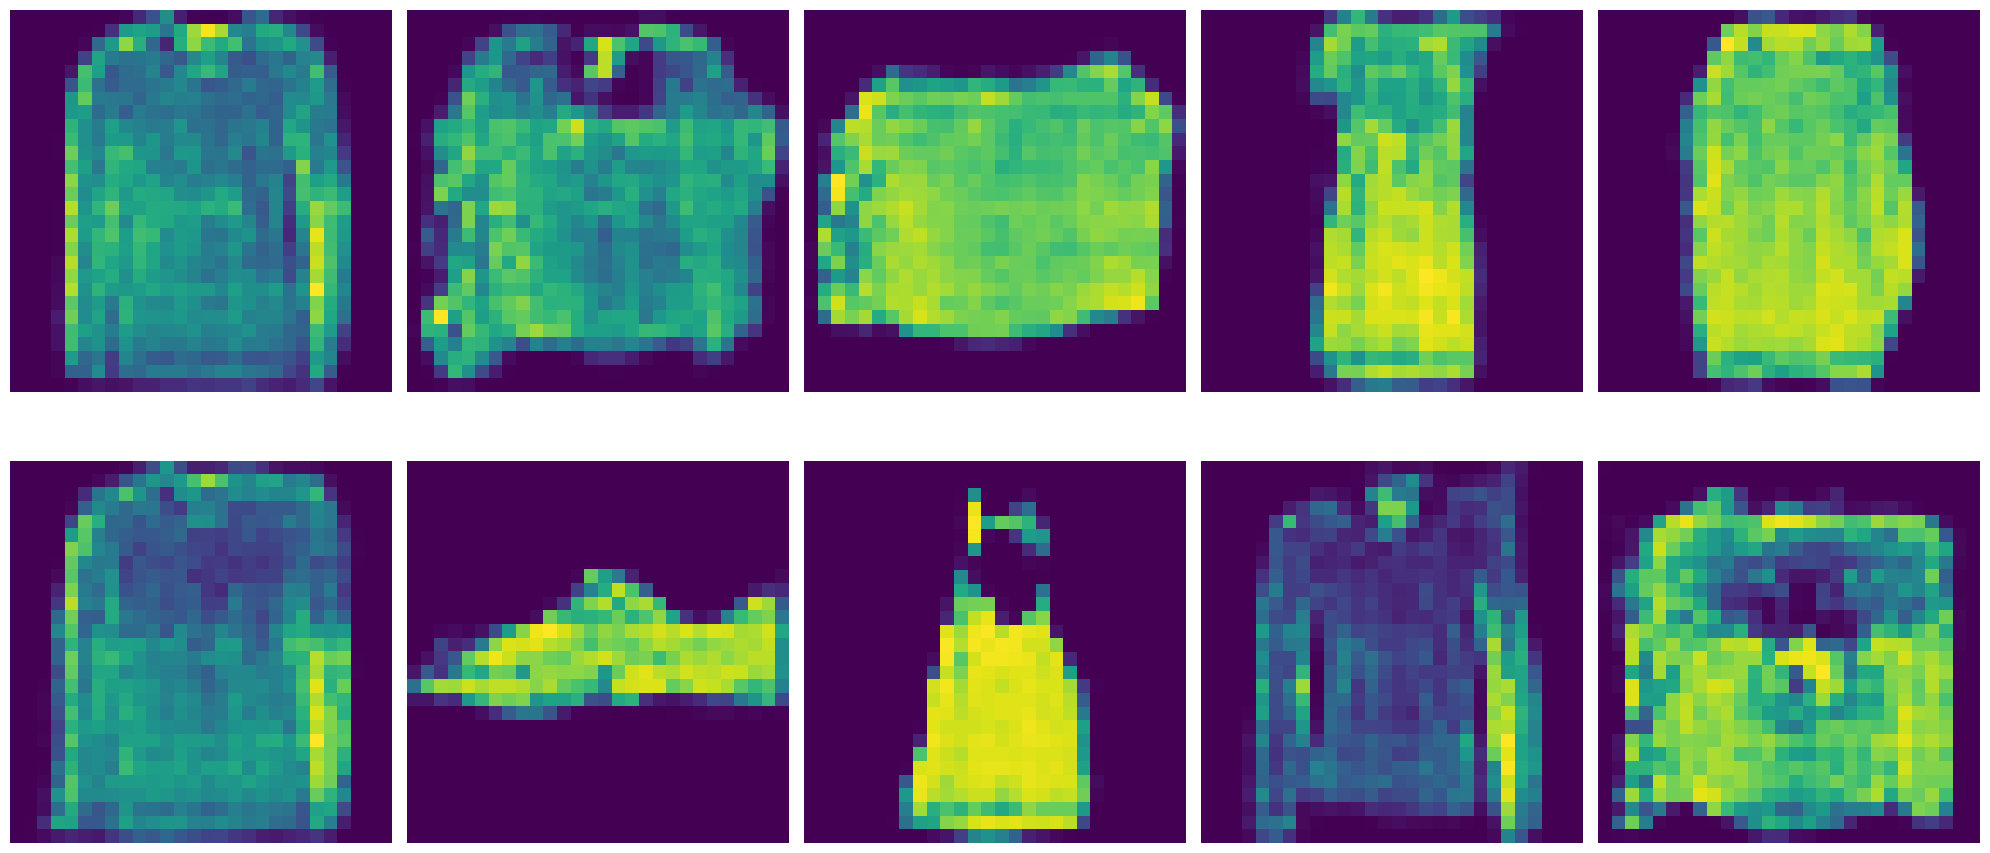

In [ ]:
for epoch in range(10):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    # Flatten the axes array to simplify indexing
    axes = axes.flatten()
    # Display each image
    for i in range(10):
        path = "generated_img_%03d_%d.png" % (epoch, i)
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

Some of the last generated images around epoch 30
(results keep improving after that):

![results](https://i.imgur.com/h5MtQZ7l.png)